### Python for street networks part 1

Retrieve, construct, analyze, and visualize street networks from OpenStreetMap

Code at Github: https://github.com/gboeing/osmnx

For the function docs: https://osmnx.readthedocs.io/en/stable/osmnx.html

For a nice intro on his blog: http://geoffboeing.com/2016/11/osmnx-python-street-networks/

Package is made by **Geoff Boeing** (Urban informatics/planning professor at Northeastern University) http://geoffboeing.com/

Some other great resources for Python for GIS analysis: https://automating-gis-processes.github.io/2016/ and https://github.com/darribas/gds17

- [The basics](#basics_dest)
- [Concrete analysis example 1: shortest path](#example_1)
- [Concrete analysis example 2: walkeable distances](#example_2)

In [31]:
# get the modules
%matplotlib inline
import requests
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import networkx as nx
from shapely.geometry import Point

from sklearn.neighbors import KDTree
import folium
ox.config(use_cache=True, log_console=True)
print (ox.__version__)
print (nx.__version__)

from IPython.display import Image

# paths
OUTPUT_PATH = 'images/'

0.8.1
2.1


In [82]:
# graph figure settings
graph_settings = {'fig_height' :10, 
                  'fig_width' :12, 
                  'node_color' :'#F42334',
                  'edge_color' :'#253F51', 
                  'edge_alpha' :.5, 
                  'node_alpha' : 1}

arrow_settings = {'arrowstyle' :"->", 
                  'connectionstyle' : "angle3,angleA=0,angleB=-90",
                  'color': '#49a347'}
bbox_settings =  {'boxstyle': "round4,pad=.5", 'fc': "0.9"}

# https://www.colorbook.io/colorschemes

<a id='basics_dest'></a>

### OMS basics

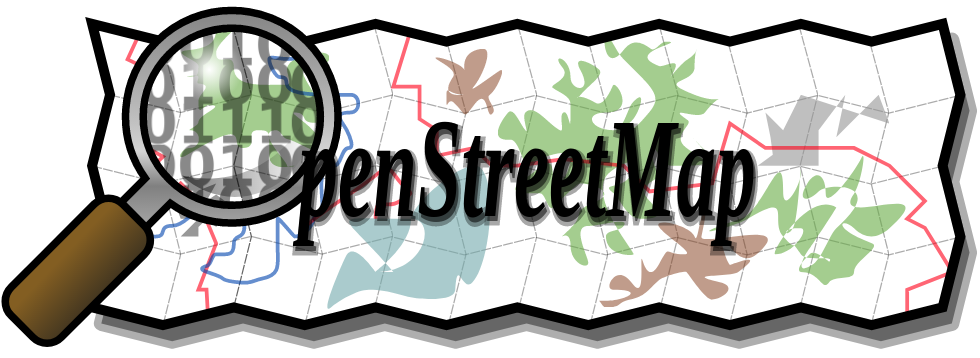

In [2]:
Image(OUTPUT_PATH + 'osm_logo.png')

OpenStreetMap (OSM) is a collaborative project to create a free editable map of the world. Rather than the map itself, the data generated by the project is considered its primary output. The creation and growth of OSM has been motivated by restrictions on use or availability of map information across much of the world, and the advent of inexpensive portable satellite navigation devices. OSM is considered a prominent example of volunteered geographic information.

Created by Steve Coast in the UK in 2004, it was inspired by the success of Wikipedia. 
https://en.wikipedia.org/wiki/OpenStreetMap

OSM github: https://github.com/openstreetmap. An awesome yearly conference State of the Map https://2018.stateofthemap.org/ is organized. 

extracts of the OSM in data in various **formats**:

- native .osm (XML)
- .pbf (compressed version of osm)
- shapefile
- GeoJson

**data model OSM**

- nodes --> points in lonlat (f.i. a bench, wastebin etc.)
- way --> ordered list of nodes (f.i.street, outline of a building)
- realtion --> ordered list containing either nodes, ways or even other relations. Used to model logical, geographic relationships between objects.

Different API's to ingest OSM data:

- native **OSM API** --> editing API for fetching and saving raw geodata from/to the OpenStreetMap database
- **Nominatim API** --> search OpenStreetMap data by name and address and to generate synthetic addresses of OSM points (reverse geocoding).
- **overpass API** --> allows us to query specific data from the OSM data set. It uses a custom query language to define the queries (overpass QL). It takes time to get used to this, but there is also the Overpass Turbo (http://overpass-turbo.eu/). This is a web based data mining tool for OpenStreetMap using Overpass API. Some examples: https://github.com/rmania/geospatial_analysis/tree/master/queries

In [81]:
overpass_amsterdam_restaurants_query = """
[out:json]; 
area[name = "Amsterdam"]->.a; 
(   
  node(area.a)[amenity=bar];
  node(area.a)[amenity=restaurant]; 
); 
out center; 
"""

In [59]:
### call this last query with Python and catch results:
overpass_url = "http://overpass-api.de/api/interpreter"
response = requests.get(overpass_url, 
                        params={'data': overpass_amsterdam_restaurants_query})
data = response.json()

# Collect coords
coords = []
for elem in data['elements']:
    lon = elem['lon']
    lat = elem['lat']
    coords.append((lon, lat))

In [60]:
# to Geopandas dataframe 
restaurants = pd.DataFrame(coords).rename(columns={0: 'lon', 1:'lat'})
restaurants['geometry'] = [Point(x,y) for x,y in zip(restaurants.lon, restaurants.lat)]
restaurants = gpd.GeoDataFrame(restaurants, geometry = 'geometry', 
                               crs={'init': 'espg:4326'})

In [62]:
restaurants.lon.idxmax() # drop outlier
restaurants = restaurants.drop(439)

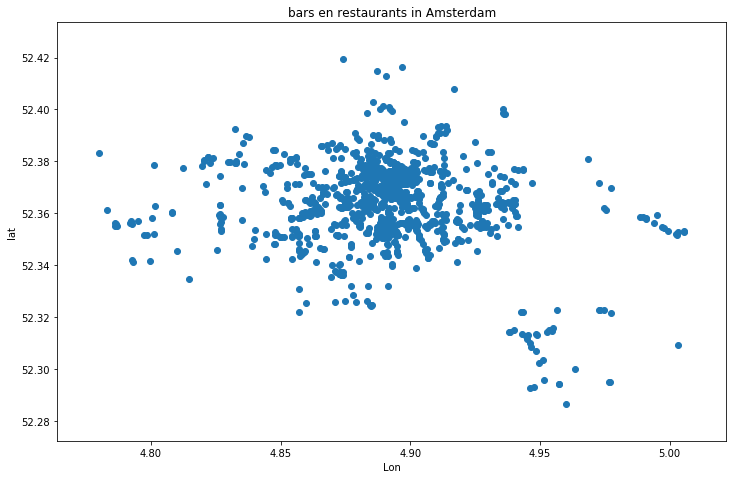

In [64]:
fig, ax = plt.subplots(figsize=[12,8])
restaurants[:].plot(ax=ax)
_ = ax.set(title = 'bars en restaurants in Amsterdam', xlabel = 'Lon', ylabel='lat')

Another way to access the Overpass API with Python is by using the **overpy** package as a wrapper. docs: https://python-overpy.readthedocs.io/en/latest/

In [70]:
import overpy # pip install overpy
api = overpy.Overpass() # new instance of the Overpass() class
r = api.query(overpass_amsterdam_restaurants_query)

In [79]:
r.nodes[:2]

[<overpy.Node id=34043796 lat=52.2929232 lon=4.9475644>,
 <overpy.Node id=34044093 lat=52.3737497 lon=4.8935952>]

In [74]:
coords  = []
coords += [(float(node.lon), float(node.lat)) for node in r.nodes]

Build cool things some examples: https://github.com/njanakiev/openstreetmap-heatmap.

## **OSMnx** 

Python package that lets you download **spatial geometries** and construct, project, visualize, and analyze street networks from OpenStreetMap's APIs. Users can download and construct walkable, drivable, or bikable urban networksand then easily analyze and visualize them.

**graph_from_place** from OSM data within the spatial boundaries of some geocodable place(s)

OSM builds topologically-corrected street networks, projects and plot the networks.The street networks are directed and preserve one-way directionality. 

Download a street network with 

- a bounding box
- a lat-long point plus a distance
- an address plus a distance
- a place name or list of place names (to automatically geocode and get the boundary of)
- a polygon of the desired street network's boundaries

You can also specify several different network types:

- 'drive' - get drivable public streets (excl. service roads)
- 'drive_service' - get drivable streets + service roads
- 'walk' - get all streets and paths for pedestrians (ignoring 1-way directionality)
- 'bike' - get all streets and paths for cyclists
- 'all' - download all non-private OSM streets and paths (= DEFAULT)
- 'all_private' - download all OSM streets and paths incl. private-access ones

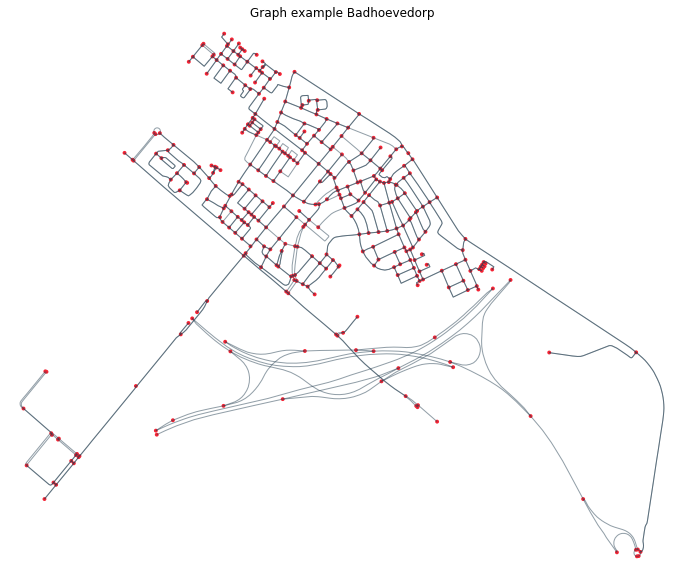

In [83]:
G = ox.graph_from_place('badhoevedorp, Netherlands', network_type='drive')
fig, ax = ox.plot_graph(ox.project_graph(G), show=False, close=False, **graph_settings)
_ = ax.set(title = 'Graph example Badhoevedorp')

**graph_from_address** Create a networkx graph from OSM data within some distance of some address.

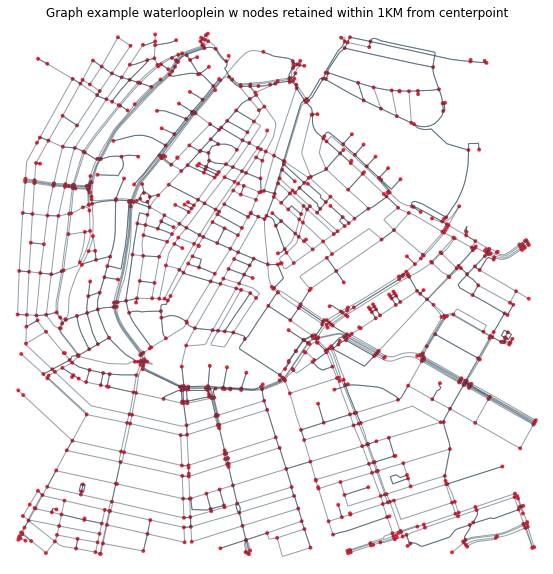

In [84]:
# get a street network and plot it with all edge intersections
address = 'waterlooplein, amsterdam'
G = ox.graph_from_address(address, network_type='bike', distance=1000)
fig, ax = ox.plot_graph(G, show=False, close=False, **graph_settings)
_ = ax.set(title = 'Graph example waterlooplein w nodes retained within 1KM from centerpoint')

**graph_from_bbox** --> constructs the network from all the OSM nodes and ways within the bounding box

In [85]:
# nice site to get bounding boxes: https://boundingbox.klokantech.com/
# bbox = min Longitude , min Latitude , max Longitude , max Latitude
bbox_ams_4326 = [4.932959, 52.373848, 4.949338, 52.380755]
bbox_ams_osm = [52.380755, 52.373848,  4.949338, 4.932959] # N, S, E, W 

G = ox.graph_from_bbox(bbox_ams_osm[0], bbox_ams_osm[1], bbox_ams_osm[2], bbox_ams_osm[3], 
                       simplify=True, network_type='all', name='knsm_eiland')

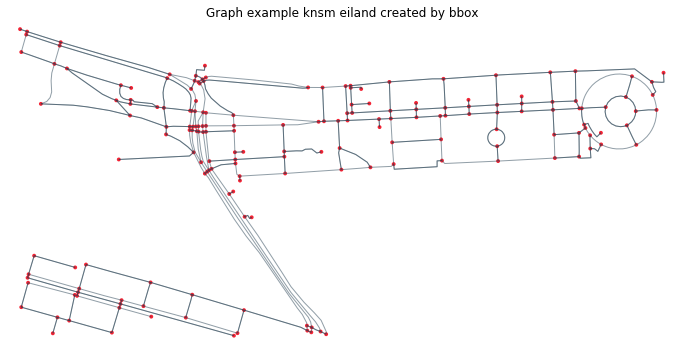

In [86]:
fig, ax = ox.plot_graph(G, show=False, close=False, **graph_settings)
_ = ax.set(title = 'Graph example knsm eiland created by bbox')

**graph_from_polygon** requires a polygon in units of lat-long

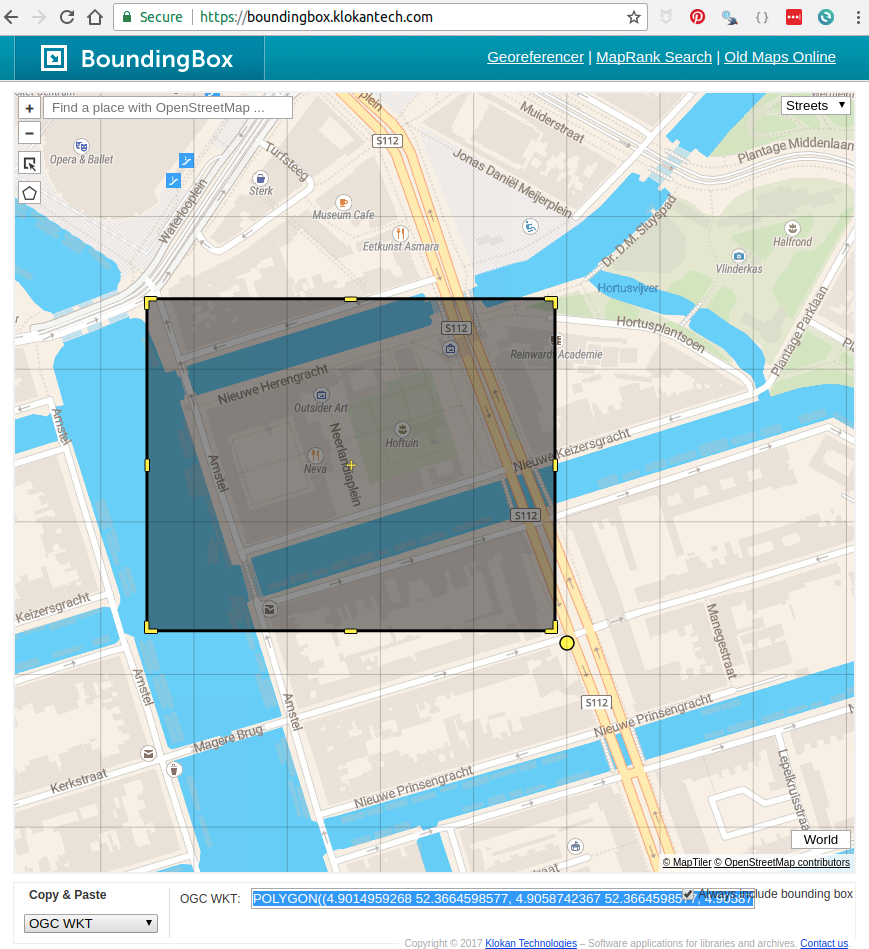

In [87]:
Image(OUTPUT_PATH + 'klokantech_bbx_polies.png', width =800)

In [88]:
from shapely.wkt import loads
wkt = 'MULTIPOLYGON(((4.9014959268 52.3664598577, 4.9058742367 52.3664598577, 4.9058742367 52.3642848316, 4.9014959268 52.3642848316, 4.9014959268 52.3664598577)))'
geom = loads(wkt)
G = ox.graph_from_polygon(geom, simplify=True, network_type='all')

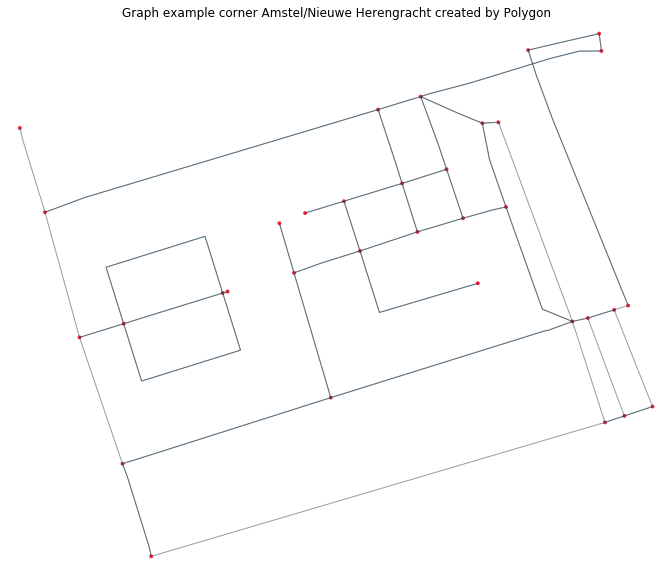

In [89]:
fig, ax = ox.plot_graph(G, show=False, close=False, **graph_settings)
_ = ax.set(title = 'Graph example corner Amstel/Nieuwe Herengracht created by Polygon')

### basic stats

Calculate basic descriptive metric and topological stats for a graph.

Here we can use all the shapely functions

In [120]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G) 
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area 
graph_area_m

3772709.16784563

In [121]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')

{'circuity_avg': 1.0228546489361068,
 'clean_intersection_count': 443,
 'clean_intersection_density_km': 117.42225024278004,
 'edge_density_km': 37000.60136883352,
 'edge_length_avg': 53.648158339738586,
 'edge_length_total': 139592.5079999998,
 'intersection_count': 1074,
 'intersection_density_km': 284.67606492267663,
 'k_avg': 4.318672199170124,
 'm': 2602,
 'n': 1205,
 'node_density_km': 319.39912312088023,
 'self_loop_proportion': 0.0,
 'street_density_km': 28209.56460335204,
 'street_length_avg': 57.52782864864855,
 'street_length_total': 106426.48299999982,
 'street_segments_count': 1850,
 'streets_per_node_avg': 3.166804979253112,
 'streets_per_node_counts': {0: 0,
  1: 131,
  2: 38,
  3: 562,
  4: 454,
  5: 14,
  6: 5,
  7: 1},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.1087136929460581,
  2: 0.03153526970954357,
  3: 0.46639004149377594,
  4: 0.3767634854771784,
  5: 0.011618257261410789,
  6: 0.004149377593360996,
  7: 0.0008298755186721991}}

### cleaning up a network

Simplification is normally done by OSMnx automatically under the hood, but we can break it out to see how it works. OpenStreetMap nodes are weird. They include intersections, but they also include all the points along a single block where the street curves. The latter are not nodes in the graph theory sense, so we remove them algorithmically and consolidate the set of edges between "true" network nodes into a single edge.

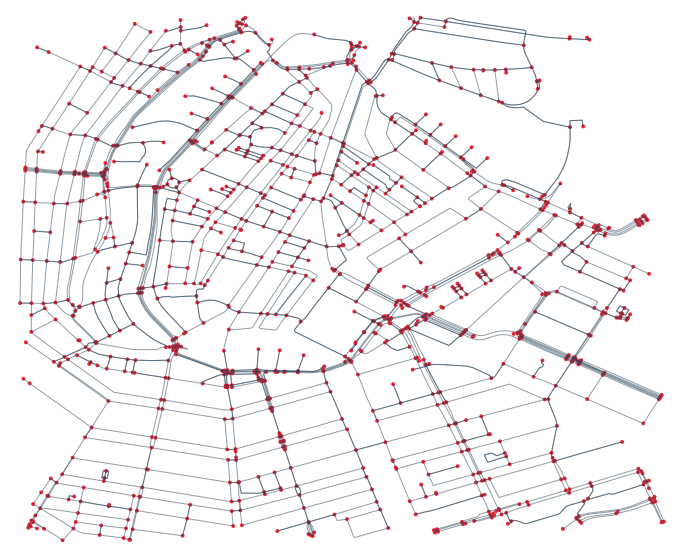

In [27]:
# get a street network and plot it with all edge intersections
G_proj = ox.project_graph(G) # to UTM
fig, ax = ox.plot_graph(G_proj, **graph_settings)

**Clean up the intersections**

We'll specify that any nodes with 10 meters of each other in this network are part of the same intersection. 

- Adjust this tolerance based on the street design standards
- use a projected graph to work in meaningful units like meters. 
- specify that we do not want dead-ends returned in our list of cleaned intersections. 
- extract xy coordinates 
- plot clean intersections compared to the topological edge intersections above.

In [32]:
# clean up the intersections and extract their xy coords
intersections = ox.clean_intersections(G_proj, tolerance=10, dead_ends=False)
points = np.array([point.xy for point in intersections])

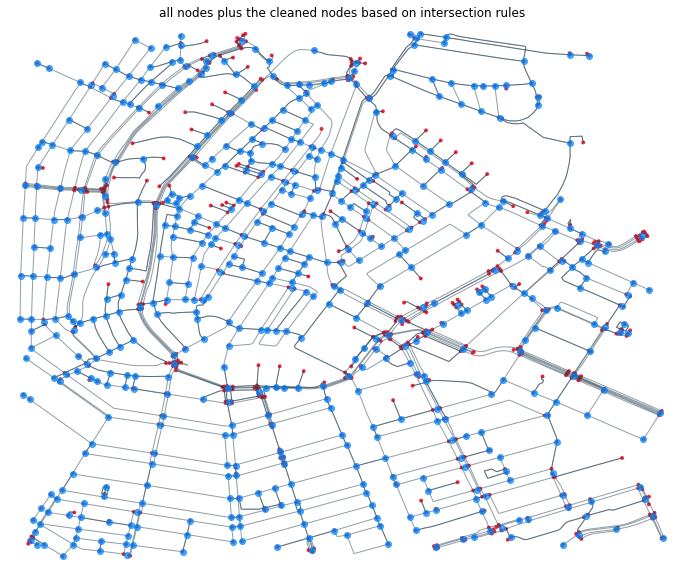

In [36]:
# plot the cleaned-up intersections
fig, ax = ox.plot_graph(G_proj, show=False, close=False, **graph_settings)
# overlay the reduced intersections
ax.scatter(x=points[:,0], y=points[:,1], zorder=2, color='#0088FF', alpha=.7)
_ = ax.set(title = 'all nodes plus the cleaned nodes based on intersection rules')
plt.show()

In [90]:
G = ox.graph_from_address('Meeuwenlaan 33, Amsterdam', 
                             distance=500, network_type='drive', simplify=False)

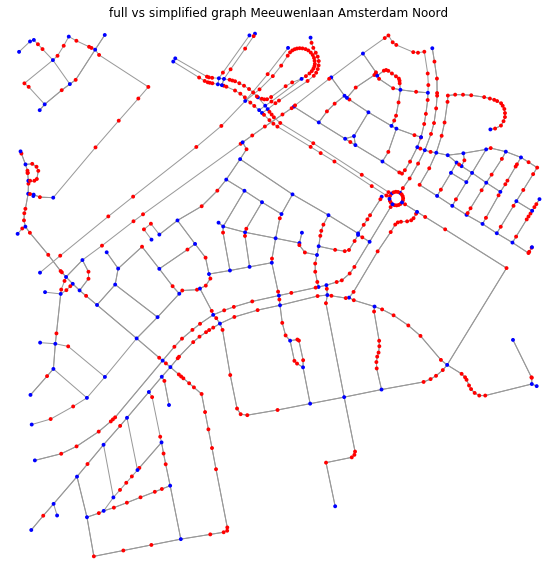

In [95]:
# Return True if the node is a "real" endpoint of an edge in the network
nc = ['b' if ox.is_endpoint(G, node) else 'r' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_zorder=3,
                        show=False, close=False, fig_height = 10, fig_width =15)
_ = ax.set(title = 'full vs simplified graph Meeuwenlaan Amsterdam Noord')

In [96]:
G2 = G.copy()
# Simplify a graph's topology by removing all nodes that are not intersections or dead-ends
G2 = ox.simplify_graph(G2)

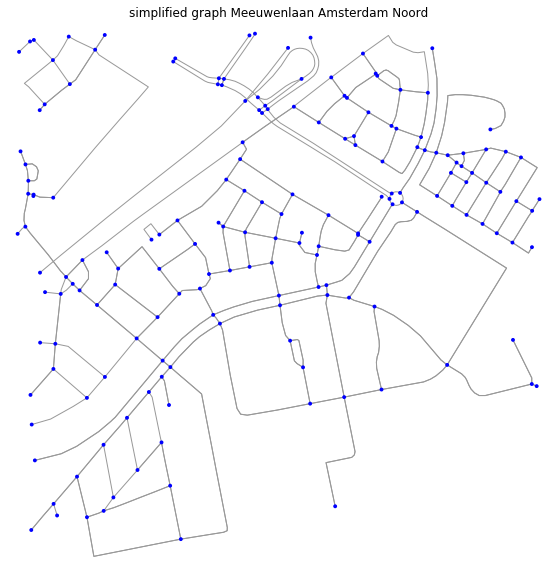

In [102]:
fig, ax = ox.plot_graph(G2, node_color='b', node_zorder=3, 
                       show=False, close=False, fig_height = 10, fig_width =15)
_ = ax.set(title = 'simplified graph Meeuwenlaan Amsterdam Noord')

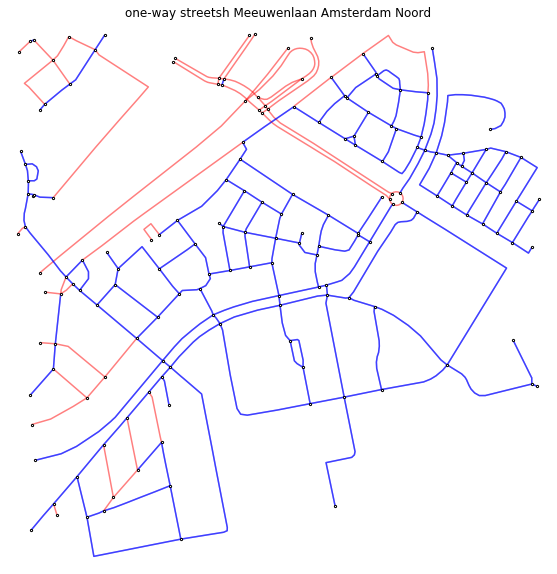

In [103]:
# highlight one-way streets
ec = ['r' if data['oneway'] else 'b' for u, v, key, data in G2.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G2, node_color='w', node_edgecolor='k', node_size=5, 
                        node_zorder=3, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.5,
                        show=False, close=False, fig_height = 10, fig_width =15)
_ = ax.set(title = 'one-way streetsh Meeuwenlaan Amsterdam Noord')

<a id='example_1'></a>

### Concrete analysis example 1: shortest path  

Let's calculate the quickest route from DataLab to the Oudezijdsvoorburgwal 300. 

In [59]:
# Get the graph
address = 'waterlooplein, amsterdam'
distance = 1000 #1KM

start = ox.geocode('Weesperstraat 113, Amsterdam')
end = ox.geocode('oudezijds voorburgwal 300, amsterdam')
print (start) #datalab
print (end) # oz

(52.3630173, 4.9072382)
(52.3712198, 4.8953522)


In [60]:
G = ox.graph_from_address(address, network_type='bike', distance=distance)

Text(4.90224,52.362,'Datalab')

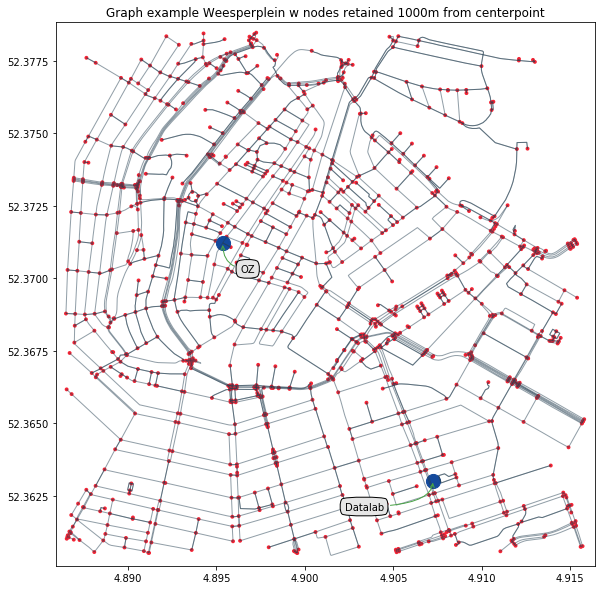

In [58]:
# plot 
fig, ax = ox.plot_graph(G, show=False, close=False, **graph_settings, axis_off=False)
#annotate plot
_ = ax.set(title = 'Graph example Weesperplein w nodes retained {}m from centerpoint'.format(distance))
ax.scatter(end[1], end[0], c='#144a9c', s=200)
ax.scatter(start[1], start[0], c='#144a9c', s=200)
ax.annotate('OZ', xy = (end[1], end[0]), 
            xytext=(end[1] +.001, end[0] -.001), bbox=bbox_settings, 
            arrowprops=arrow_settings)
ax.annotate('Datalab', xy = (start[1], start[0]), 
            xytext=(start[1] -.005, start[0] -.001), bbox=bbox_settings, 
            arrowprops=arrow_settings)

In order to do this efficiently let's first creat a KDTree for fast generalized N-point problems

This enables fast nearest neighbor (NN) queries among high dimensional data points. A k-d tree makes finding our optimal nodes easy and efficient. 

 **KD-tree search steps**
 
 - pick a random atrribute
 - for that attribute find the median and use this to split the dataset (half of datapoint on 1 side) = balanced data structure
 - continue this procedure 
 - use this to find your neigherst neighbours for a newly selected point (datalab / OZ data point in this case) --> find the regions of the data this Point geometry is contained in and compare to all Points in this region. Recursively select to suibtree to search in.

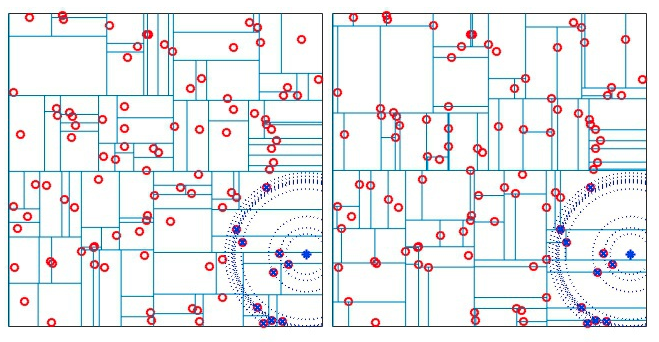

In [11]:
Image(filename= OUTPUT_PATH + 'kdtree_algorithm.png', width=1500, height=200)

In [61]:
tree = KDTree(nodes[['y', 'x']], metric='euclidean', leaf_size= 10)

start_idx = tree.query([start], k=1, return_distance=False)[0]
end_idx = tree.query([end], k=1, return_distance=False)[0]
closest_node_to_start = nodes.iloc[start_idx].index.values[0]
closest_node_to_end = nodes.iloc[end_idx].index.values[0]

route = nx.shortest_path(G, closest_node_to_start, closest_node_to_end)
print ('list of nodes between : {} and {} = {}'.format(start_idx, end_idx, route))

NameError: name 'nodes' is not defined

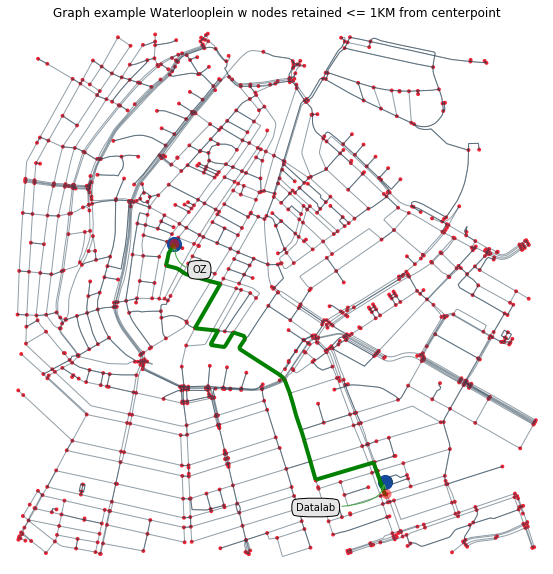

In [25]:
fig, ax = ox.plot_graph_route(G, route, show=False, close=False, **graph_settings,
                         route_color = 'green', route_alpha=1)
_ = ax.set(title = 'Graph example Waterlooplein w nodes retained <= 1KM from centerpoint')
ax.scatter(end[1], end[0], c='#144a9c', s=200)
ax.scatter(start[1], start[0], c='#144a9c', s=200)

ax.annotate('OZ', xy = (end[1], end[0]), 
            xytext=(end[1] +.001, end[0] -.001), bbox=bbox_settings, 
            arrowprops=arrow_settings)
ax.annotate('Datalab', xy = (start[1], start[0]), 
            xytext=(start[1] -.005, start[0] -.001), bbox=bbox_settings, 
            arrowprops=arrow_settings)

plt.show()

In [26]:
# plot on folium --> folium builds on strengths of the Python ecosystem + 
# mapping strengths of the Leaflet.js library. (open-source JavaScript library)
m = ox.plot_route_folium(G, route, route_color='green')
folium.Marker(location=start,
              icon=folium.Icon(color='red'), popup='Datalab').add_to(m)
folium.Marker(location=end,
              icon=folium.Icon(color='blue'), popup='OZ').add_to(m)
m

<a id='example_2'></a>

### concrete example 2: walkeable distances

In [37]:
df_nodes = ox.graph_to_gdfs(G, nodes=True, edges=False)

In [38]:
x, y = df_nodes['geometry'].unary_union.centroid.xy
center_node = ox.get_nearest_node(G, (y[0], x[0]))

In [59]:
network_type = 'walk'
trip_times = [1, 3, 5, 7, 10, 12, 15, 25] #in minutes
travel_speed = 4.5 #walking speed in km/hour

In [60]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [61]:
# get one color for each isochrone
iso_colors = ox.get_colors(n=len(trip_times), cmap='plasma', start=0.3, return_hex=True)

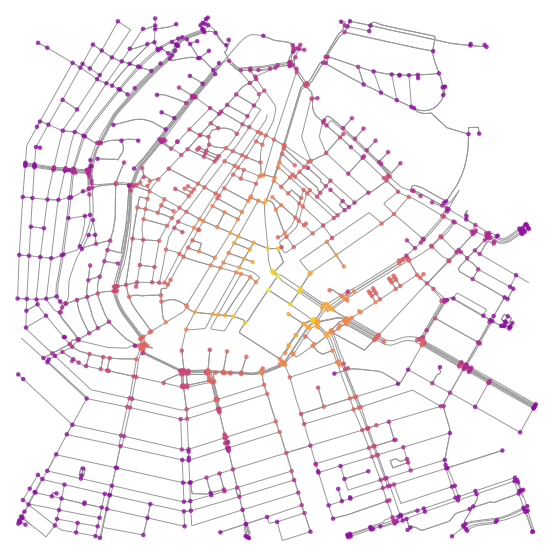

In [62]:
# color the nodes according to isochrone then plot the street network

node_colors = {}

for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    
    for node in subgraph.nodes():
        node_colors[node] = color
        
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]

fig, ax = ox.plot_graph(G, fig_height=graph_settings['fig_height'], 
                        fig_width = graph_settings['fig_width'],
                        node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)

In [52]:
from shapely.geometry import Point, LineString, Polygon
from descartes import PolygonPatch
import geopandas as gpd
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

ValueError: A polygon or multi-polygon representation is required

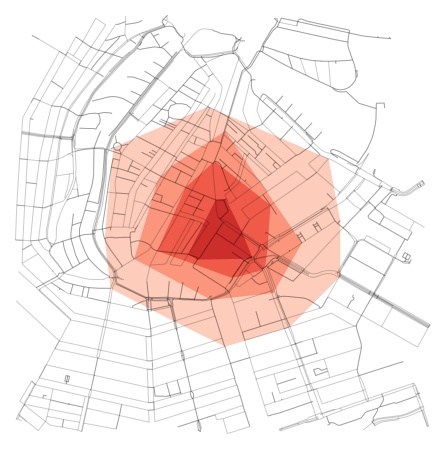

In [53]:
#plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, fig_height=8, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

### save graph to disk as shapefile (for GIS) or graphml file (for gephi etc)

In [46]:
ox.save_graph_shapefile(G, filename='mynetwork_shapefile', folder = OUTPUT_PATH)
ox.save_graphml(G, filename='mynetwork.xml',folder= OUTPUT_PATH)